# <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=400 align="left"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=400 align="left"/><br><br><br><br><br>



# Convert ALOS-1 Data to GCOV

In preparation for NISAR, this notebook does:
- ALOS-1 L1.0 (must be StripMap) to NISAR L0B with https://github.com/isce-framework/isce3/blob/develop/share/nisar/examples/alos_to_nisar_l0b.py
- NISAR L0B to RSLC with https://github.com/isce-framework/isce3/blob/develop/python/packages/nisar/workflows/focus.py
- NISAR DEM staging with https://github.com/isce-framework/isce3/blob/develop/python/packages/nisar/workflows/stage_dem.py 
- NISAR RSLC to GCOV with and https://github.com/isce-framework/isce3/blob/develop/python/packages/nisar/workflows/gcov.py


Requirements:
- a GPU instance in the On-Demand System 
- updated ISCE3 repo and installed isce3_src conda environment
- notebook kernel set to isce3_src


for questions/feedback, contact Alex Christensen

In [1]:
import os
import sys
from pathlib import Path
import subprocess
import fnmatch
import zipfile
import h5py
from string import Template
from osgeo import gdal
import numpy as np
import math
import boto3
import shutil
import matplotlib.pyplot as plt
import imageio
import asf_search as asf
from shapely import Polygon
import json
import glob

from yaml import safe_load, safe_dump


## Set directories

Files should not be stored in scratch after processing due to costs. Files will be moved to the S3 bucket after processing. 

In [2]:
notebook_dir = Path(os.getcwd())
working_dir = Path('/scratch/alex_eco_test/') ## set to your own scratch space 

HOME_DIR = os.environ['HOME']
ISCE3_BUILD_DIR = os.environ.get('ISCE3_BUILD_DIR', f'{HOME_DIR}/isce3/build')

Currently, ALOS-1 zip files are saved to nisar-st-data-ondemand/ALOS1_zip/ and all processed files (L0B, RSLC, GCOV, DEMs, etc) are moved to nisar-st-data-ondemand/ALOS1_processed/ at the end of the notebook.

In [3]:
bucket_name = "nisar-st-data-ondemand"
s3_path = 'ALOS1_zip/'
s3 = boto3.client("s3")
response = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix = s3_path)
contents = response.get('Contents')
existing_ALOS2_zipfiles = [contents[i].get('Key').split('/')[-1] for i in range(len(contents)) if '.zip' in contents[i].get('Key')]
existing_ALOS2_zippaths = [contents[i].get('Key') for i in range(len(contents)) if '.zip' in contents[i].get('Key')]


## Choose your AOI

New directories will be made to store files for this AOI.
For ALOS1, naming conventions are flexible.
For ALOS2, AOI names must match the "Request" name in the ALOS2 ASF Spreadsheet


In [4]:
aoi = 'talib'

aoi_str = aoi.replace(" ", "_")
aoi_dir = working_dir/aoi_str
Path(aoi_dir).mkdir(parents=True, exist_ok=True)

ALOS1_dir = aoi_dir / 'ALOS1'


## Get ALOS-1 data from ASF

There are many search options. See https://docs.asf.alaska.edu/asf_search/searching/ for more details.

The cell below allows for searching by:
- platform
- date
- processing level (must be L1.0 for this noteobok)
- flight direction
- orbit #
- frame # 
- beamModeType (cannot be StripMap, current search choices for fine beam are FBS (single pol), FBD (dual pol), and PLR (quad pol)
- polygon defined in a geojson.




In [5]:
search_by_wkt = False

opts = {
        'platform':asf.PLATFORM.ALOS,
        'processingLevel': 'L1.0',
        # 'start':'January 1, 2011',
        # 'end':'May 1, 2011',
        'beamMode': ['FBS','FBD','PLR']
        # 'maxResults':5,
        # 'flightDirection':asf.FLIGHT_DIRECTION.ASCENDING,
        }

if search_by_wkt: ## Requires a geojson within the AOI directory. 
    gdf = json.loads(open('%s.geojson' %(aoi_dir/aoi)).read())
    wkt = str('Polygon((')
    points = len(gdf['features'][0]['geometry']['coordinates'][0][0])
    for i in range(points):
        wkt = wkt + str(gdf['features'][0]['geometry']['coordinates'][0][0][i][0]) + ' ' + str(gdf['features'][0]['geometry']['coordinates'][0][0][i][1]) 
        if i<points-1:
            wkt = wkt + ','
    wkt = wkt + '))'
    results = asf.geo_search(intersectsWith=wkt, **opts)

else: ## Searches by orbit and frame, if these are known.
    opts.update({
                'absoluteOrbit': [25487], ## orbit from talib
                'asfFrame':1440 ##frame from talib
                })
    results = asf.search(**opts)


list_of_ALOS_SLCs = [results.geojson()['features'][x]['properties']['url'] for x in range(len(results.geojson()['features']))]
print('\n'.join(list_of_ALOS_SLCs))

frames = list(np.unique([f.split('-')[0][-4:] for f in list_of_ALOS_SLCs]))
# print('\n'.join(frames))



https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP254871440-L1.0.zip


**The notebook assumes you will run a stack of data that will be co-located. Therefore, if you want to process several frames, you should run this notebook one frame at a time.**

In [6]:
frame = input('which frame do you want to process? %s' %(frames))
# list_of_ALOS_SLCs = [k for k in all_results if frame in k]
indices = [frames.index(k) for k in frames if frame in k]
[list_of_ALOS_SLCs[i] for i in indices]


which frame do you want to process? ['1440'] 1440


['https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP254871440-L1.0.zip']

## Set directories for this particular frame

In [7]:
frame_dir = aoi_dir / frame

RSLC_dir = frame_dir / 'RSLC'
L0B_dir = frame_dir / 'L0B'
DEM_dir = frame_dir / 'DEM'
GCOV_dir = frame_dir / 'GCOV'
TMP_dir = frame_dir / 'TMP'

Path(frame_dir).mkdir(parents=True, exist_ok=True)
Path(RSLC_dir).mkdir(parents=True, exist_ok=True)
Path(L0B_dir).mkdir(parents=True, exist_ok=True)
Path(ALOS1_dir).mkdir(parents=True, exist_ok=True)
Path(DEM_dir).mkdir(parents=True, exist_ok=True)
Path(GCOV_dir).mkdir(parents=True, exist_ok=True)
Path(TMP_dir).mkdir(parents=True, exist_ok=True)


## Download the ALOS1 files from ASF
Your .netrc file must be configured with your Earthdata login and password

Add this line to your /home/jovyan/.netrc file:

- *machine urs.earthdata.nasa.gov login* **username** *password* **password**

In [8]:
ALOS1_ids = []
response = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix = s3_path)
            # MaxKeys=100)
            # Delimiter = '/')
contents = response.get('Contents')
existing_ALOS1_zipfiles = [contents[i].get('Key').split('/')[-1] for i in range(len(contents)) if '.zip' in contents[i].get('Key')]
existing_ALOS1_zippaths = [contents[i].get('Key') for i in range(len(contents)) if '.zip' in contents[i].get('Key')]

for i in indices:
    filename =  list_of_ALOS_SLCs[i].split('/')[-1]
    ALOS1_ids.append(filename)
    print('Requested File: ', filename)
    print(os.path.isdir(ALOS1_dir/filename.split('/')[-1][:-4]))
    print(os.path.isfile(ALOS1_dir/filename))
    print((filename in existing_ALOS1_zipfiles))
    if os.path.isdir(ALOS1_dir/filename.split('/')[-1][:-4])==True & (filename in existing_ALOS1_zipfiles)==True:
        print('ALOS1 is stored on S3 and already available locally and unzipped')
    elif (os.path.isfile(ALOS1_dir/filename)==False) & (filename in existing_ALOS1_zipfiles):
        i = existing_ALOS1_zipfiles.index(filename)
        s3_path_new = existing_ALOS1_zippaths[i]
        print('\tALOS1 zip is already available at S3 PATH: ', s3_path_new)
        print('\tMove ALOS1 zip from S3 to local')
        s3.download_file(bucket_name, s3_path_new , ALOS1_dir/filename)
        
    elif (os.path.isfile(ALOS1_dir/filename)==False) & (filename not in existing_ALOS1_zipfiles):
        print('\tALOS1 is not available anywhere')
        print('\tDownloading ALOS1 zip ')
        try:
            results[i].download(path=ALOS1_dir)#, session=session)
        except:
            print('Your .netrc file is not configured. We will authenticate a session with your username and password')
            user = input('What is your earthdata username?')
            psw = input('What is your earthdata password?')
            session = asf.ASFSession().auth_with_creds(user, pwd)
            results[i].download(path=ALOS1_dir, session=session)
        print('\tMoving a copy ALOS1 zip to S3 bucket')
        s3.upload_file(Filename= str(ALOS1_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))


    elif (os.path.isfile(ALOS1_dir/filename)==True) & (filename not in existing_ALOS1_zipfiles):
        print('\tALOS1 is available locally, but not on S3')
        print('\tMoving a copy ALOS1 zip to S3 bucket')
        s3.upload_file(Filename= str(ALOS1_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))

    else: 
        print('\tALOS1 zip file exists locally and on S3')
        
    if os.path.isdir(ALOS1_dir/filename.split('/')[-1][:-4])==False:
        print('\tunzipping the ALOS1 file locally')
        try:
            with zipfile.ZipFile(ALOS1_dir/filename, 'r') as zip_ref:
                zip_ref.extractall(ALOS1_dir)
        except:
            print('\tALOS1 zip is bad, re-downloading')
            os.remove(ALOS1_dir/filename)
            command = f"wget -P {ALOS1_dir} -q {file}"
            output = subprocess.check_output(command, shell=True)
            print('\t\tMoving a copy ALOS1 zip to S3 bucket')
            s3.upload_file(Filename= str(ALOS1_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))
            with zipfile.ZipFile(ALOS1_dir/filename, 'r') as zip_ref:
                zip_ref.extractall(ALOS1_dir)
        print('\t\tdeleting the local zip file')
        os.remove(ALOS1_dir/filename) ## comment to remove the alos2 zip file from your local workspace
    

Requested File:  ALPSRP254871440-L1.0.zip
True
True
True
ALOS1 is stored on S3 and already available locally and unzipped


## Get a list of folders for each ALOS1 file

In [9]:
ALOS1folders = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(ALOS1_dir)
                for f in fnmatch.filter(dirnames,'*%s*' %(frame))]
ALOS1folders.sort()
ALOS1folders

['/scratch/alex_eco_test/talib/ALOS1/ALPSRP254871440-L1.0']

## Convert ALOS1 L1.0 to NISAR L0B format

In [10]:
for ALOS1folder in ALOS1folders[:]:
    ALOS1_id = ALOS1folder.split('/')[-1]
    print('')
    print(ALOS1_id)
    
    if os.path.isfile(f"{L0B_dir/ALOS1_id}.h5")==True:
        print('NISAR RSLC already converted')
    else:

        print('')
        !mamba run --no-capture-output -n isce3_src python /home/jovyan/isce3/share/nisar/examples/alos_to_nisar_l0b.py -i {ALOS1folder} -o {L0B_dir/ALOS1_id}.h5
        


ALPSRP254871440-L1.0
NISAR RSLC already converted


In [11]:
ALOS1_L0Bs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(L0B_dir)
                for f in fnmatch.filter(files,'*.h5')]
ALOS1_L0Bs.sort()
ALOS1_L0Bs


['/scratch/alex_eco_test/talib/1440/L0B/ALPSRP254871440-L1.0.h5']

## Process NISAR L0B to NISAR RSLC

uses focus.py

In [12]:
for L1 in ALOS1_L0Bs[:]:
    ALOS1_id = L1.split('/')[-1].split('-')[0]#[:-3]
    print('')
    print(ALOS1_id)
    
    with open('/home/jovyan/NISAR_Prep_Workflows/runconfig_rslc.yaml') as f:
        doc = safe_load(f)
    doc['runconfig']['groups']['input_file_group']['input_file_path']=  [L1]
    doc['runconfig']['groups']['worker']['gpu_id'] = 0
    doc['runconfig']['groups']['product_path_group']['sas_output_file']=str(RSLC_dir/(ALOS1_id + '_rslc.h5'))

    with open(RSLC_dir/(ALOS1_id + '_rslc.yaml'), 'w') as f:
        safe_dump(doc, f, default_flow_style=False)
            

    if os.path.isfile(f"{RSLC_dir/ALOS1_id}_rslc.h5")==True:
        print('NISAR RSLC already converted')
    else:
        try: os.remove(f"{RSLC_dir/ALOS1_id}_rslc.h5")
        except:''
        !mamba run --no-capture-output -n isce3_src python {ISCE3_BUILD_DIR}/packages/nisar/workflows/focus.py {str(RSLC_dir/(ALOS1_id + '_rslc.yaml'))}



ALPSRP254871440
NISAR RSLC already converted


In [13]:
NISAR_RSLCs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(RSLC_dir)
                for f in fnmatch.filter(files,'*_rslc.h5')]
NISAR_RSLCs.sort()
NISAR_RSLCs


['/scratch/alex_eco_test/talib/1440/RSLC/ALPSRP254871440_rslc.h5']


ALPSRP254871440_rslc
Width x Height: 9953 29541


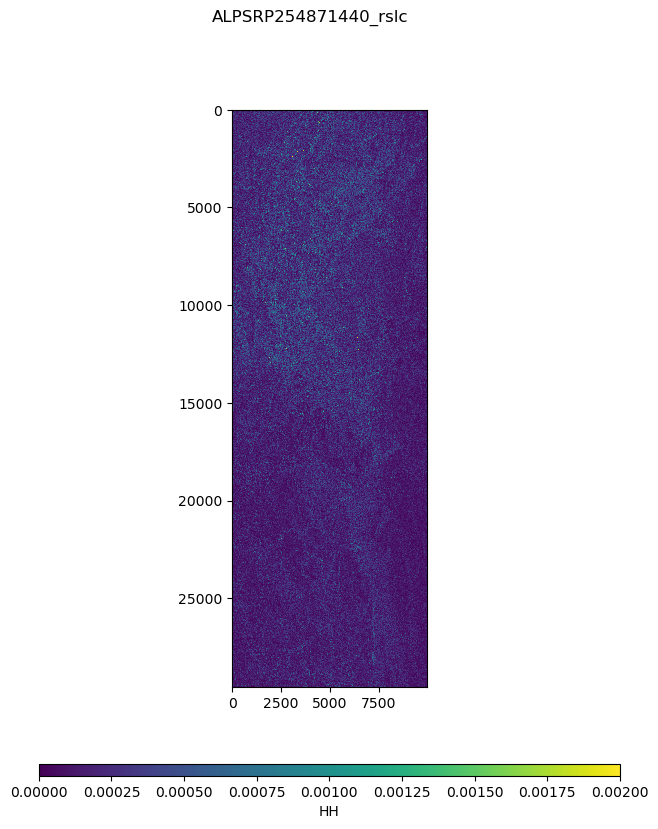

In [16]:
for NISAR_RSLC in NISAR_RSLCs[:]:
    ALOS2_id = NISAR_RSLC.split('/')[-1][:-3]
    print('')
    print(ALOS2_id)
    f = h5py.File(f"{RSLC_dir/ALOS2_id}.h5", "r") 
    a_group_key = list(f.keys())[0]
    HH = f[a_group_key]['LSAR']['RSLC']['swaths']['frequencyA']['HH'][()]
    amplitude = abs(HH)
    print('Width x Height:' , HH.shape[1], HH.shape[0])
    
    fig, ax1 = plt.subplots(1,1,figsize = (15,10))
    im1 = ax1.imshow(amplitude, interpolation = 'nearest',
          vmin=0,vmax=0.002,cmap='viridis')
    cbar1 = plt.colorbar(im1, ax=ax1,
            shrink=0.5, orientation='horizontal',
            pad=0.1, aspect=50,label='HH')

    plt.suptitle(ALOS2_id)
    plt.savefig(RSLC_dir/ (ALOS2_id + '_HH-HV.png'))


## Get a DEM for the first RSLC file in the stack 

uses stage_dem.py

The same DEM will be used for all RSLCs in the stack

In [17]:
ALOS1_ref = NISAR_RSLCs[0].split('/')[-1].split('_')[0]#[:-3]
print('')
print(ALOS1_ref)

## Get NISAR DEM  

if os.path.isfile(f"{DEM_dir/ALOS1_ref}.vrt")==False:
    !mamba run --no-capture-output -n isce3_src {ISCE3_BUILD_DIR}/packages/nisar/workflows/stage_dem.py -p {RSLC_dir/ALOS1_ref}_rslc.h5 -o {DEM_dir/ALOS1_ref}.vrt



ALPSRP254871440


## Set GCOV configurations
If you want to change to UTM coordiates, set utm = True and choose the x and y posting. The default is 20m

In [18]:
x_posting = ''
y_posting = ''
EPSG = ''

utm = True
if utm:
    src = gdal.Open(f"{DEM_dir/ALOS1_ref}.vrt")
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)

    x1,y1,x2,y2 = math.floor(ulx),math.floor(uly),math.floor(lrx),math.floor(lry)
    zone = int(np.ceil((ulx + 180)/6))

    if y1>=0:
        EPSG = 32600+zone
    elif y1<0:
        EPSG = 32600+zone

    x_posting = 20
    y_posting = 20
    
print(EPSG)



32605


## Run the GCOV processor on the first/reference image in the stack. 
uses gcov.py

This image will be used to determine the bounding box of the remaining images in the stack

In [20]:
def setup_gcov_runconfig(fid,uly='',ulx='',lry='',lrx=''):
    with open('/home/jovyan/isce3/share/nisar/defaults/gcov.yaml') as f:
        doc = safe_load(f)
    doc['runconfig']['groups']['input_file_group']['input_file_path']=  f"{RSLC_dir/fid}_rslc.h5"
    doc['runconfig']['groups']['product_path_group']['sas_output_file']=  f"{GCOV_dir/fid}_gcov_{EPSG}.h5"
    doc['runconfig']['groups']['dynamic_ancillary_file_group']['dem_file'] = f"{DEM_dir/ALOS1_ref}.vrt"
    doc['runconfig']['groups']['product_path_group']['scratch_path'] = f"{TMP_dir}/"
    doc['runconfig']['groups']['processing']['geocode']['output_epsg'] = EPSG
    doc['runconfig']['groups']['processing']['geocode']['output_posting']['A']['x_posting'] = x_posting
    doc['runconfig']['groups']['processing']['geocode']['output_posting']['A']['y_posting'] = y_posting
    # doc['runconfig']['groups']['processing']['rtc']['input_terrain_radiometry'] = f"sigma0" ##f"beta0"
    if uly != '':
        doc['runconfig']['groups']['processing']['geocode']['top_left']['y_abs'] = uly
        doc['runconfig']['groups']['processing']['geocode']['top_left']['x_abs'] = ulx
        doc['runconfig']['groups']['processing']['geocode']['bottom_right']['y_abs'] = lry
        doc['runconfig']['groups']['processing']['geocode']['bottom_right']['x_abs'] = lrx
        # doc['runconfig']['groups']['processing']['geocode']['y_snap'] = ''
        # doc['runconfig']['groups']['processing']['geocode']['x_snap'] = ''
        print(uly,ulx,lry,lrx)

    with open(GCOV_dir/(fid + '_gcov.yaml'), 'w') as f:
        safe_dump(doc, f, default_flow_style=False)
            



In [ ]:
setup_gcov_runconfig(ALOS1_ref)
if os.path.isfile(f"{GCOV_dir/ALOS1_ref}_gcov_utm.h5")==False:
    !mamba run --no-capture-output -n isce3_src {ISCE3_BUILD_DIR}/packages/nisar/workflows/gcov.py {GCOV_dir/ALOS1_ref}.yaml

overwriting variable {'LD_LIBRARY_PATH'}
journal: Starting GCOV workflow
journal: Computing radar samples backscatter (HH)


## Get top left coordinates of bottom right coordinates of reference image

In [ ]:
f = h5py.File(f"{GCOV_dir/ALOS1_ref}_gcov_%s.h5" %(EPSG), "r") 
a_group_key = list(f.keys())[0]
ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object

ulx = x_posting * round(ds_x[0]/x_posting)
lrx = x_posting * round(ds_x[-1]/x_posting)
uly = y_posting * round(ds_y[0]/y_posting)
lry = y_posting * round(ds_y[-1]/y_posting)

print('Force top left to be: %s %s' %(ulx,uly))
print('Force top right to be: %s %s' %(lrx,lry))



## Process the remaining RSLC files to GCOV using the bounding box set by the reference images

In [ ]:
for NISAR_RSLC in NISAR_RSLCs[1:]:
    ALOS1_id = NISAR_RSLC.split('/')[-1].split('_')[0]
    print('')
    print(ALOS1_id)

    setup_gcov_runconfig(ALOS1_id,uly,ulx,lry,lrx)
    if os.path.isfile(f"{GCOV_dir/ALOS1_id}_gcov_{EPSG}.h5" )==False:
        !mamba run --no-capture-output -n isce3_src {ISCE3_BUILD_DIR}/packages/nisar/workflows/gcov.py {GCOV_dir/ALOS1_id}_gcov.yaml


## See final list of NISAR GCOV data files

In [ ]:
NISAR_GCOVs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(GCOV_dir)
                for f in fnmatch.filter(files,'*.h5')]
NISAR_GCOVs.sort()
NISAR_GCOVs

## Check that all H5 files have the same dimensions and extent
## Make Figures

In [ ]:
for NISAR_GCOV in NISAR_GCOVs[:]:
    ALOS2_id = NISAR_GCOV.split('/')[-1][:-3]
    print('')
    print(ALOS2_id)
    f = h5py.File(f"{GCOV_dir/ALOS2_id}.h5", "r") 
    a_group_key = list(f.keys())[0]
    ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
    ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object
    HH = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['HHHH'][()] 
    print('Width x Height:' , ds_x.shape, ds_y.shape)
    print(np.nanmean(HH))
    extent= (ds_x[0],ds_y[0],ds_x[-1],ds_y[-1]) 
    print('Top Left: ', ds_x[0],ds_y[0])
    print('Bottom Right: ', ds_x[-1],ds_y[-1])
    
    fig, ax1 = plt.subplots(1,1,figsize = (15,10))
    im1 = ax1.imshow(HH, interpolation = 'nearest',
          extent = extent, vmin=0,vmax=0.000001,cmap='viridis')
    cbar1 = plt.colorbar(im1, ax=ax1,
            shrink=0.5, orientation='horizontal',
            pad=0.1, aspect=50,label='HH')

    plt.suptitle(ALOS2_id)
    plt.savefig(GCOV_dir/ (ALOS2_id + '_HH-HV.png'))


## Make an animation

In [ ]:
all_figs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(GCOV_dir)
                for f in fnmatch.filter(files,'*.png')]
all_figs.sort()
with imageio.get_writer('%s/%s.gif' %(GCOV_dir,aoi_str),mode='I',duration=300) as writer:
    for file in all_figs:
        print(file)
        image = imageio.imread(file)
        writer.append_data(image)
        

## Clean TMP files

In [ ]:
shutil.rmtree(TMP_dir) 
shutil.rmtree(ALOS2_dir)

## Move files to S3 Bucket


In [ ]:
files = [os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(RSLC_dir)
            for f in fnmatch.filter(files,'*')]
for file in files:
    new_file = ('/').join(file.split('/')[-5:])
    command = 'aws s3 mv %s s3://nisar-st-data-ondemand/ALOS2_processed/%s' %(file,new_file)
    # print(command)
    os.system(command)
    
files = [os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(DEM_dir)
            for f in fnmatch.filter(files,'*')]
for file in files:
    new_file = ('/').join(file.split('/')[-5:])
    command = 'aws s3 mv %s s3://nisar-st-data-ondemand/ALOS2_processed/%s' %(file,new_file)
    # print(command)
    os.system(command)